<a href="https://colab.research.google.com/github/ranjuadhikari14/Potato_Disease_Detection/blob/main/potato_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import kagglehub

dataset_path = kagglehub.dataset_download("mohitsingh1804/plantvillage")
print("Path to dataset files:", dataset_path)


Path to dataset files: /kaggle/input/plantvillage


In [19]:
!ls '/kaggle/input/plantvillage/PlantVillage/train'

 Apple___Apple_scab
 Apple___Black_rot
 Apple___Cedar_apple_rust
 Apple___healthy
 Blueberry___healthy
'Cherry_(including_sour)___healthy'
'Cherry_(including_sour)___Powdery_mildew'
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
'Corn_(maize)___Common_rust_'
'Corn_(maize)___healthy'
'Corn_(maize)___Northern_Leaf_Blight'
 Grape___Black_rot
'Grape___Esca_(Black_Measles)'
 Grape___healthy
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'
'Orange___Haunglongbing_(Citrus_greening)'
 Peach___Bacterial_spot
 Peach___healthy
 Pepper,_bell___Bacterial_spot
 Pepper,_bell___healthy
 Potato___Early_blight
 Potato___healthy
 Potato___Late_blight
 Raspberry___healthy
 Soybean___healthy
 Squash___Powdery_mildew
 Strawberry___healthy
 Strawberry___Leaf_scorch
 Tomato___Bacterial_spot
 Tomato___Early_blight
 Tomato___healthy
 Tomato___Late_blight
 Tomato___Leaf_Mold
 Tomato___Septoria_leaf_spot
'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___Target_Spot
 Tomato___Tomato_mosaic_virus
 Tomato_

In [20]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [21]:
path_train = '/kaggle/input/plantvillage/PlantVillage/train'
path_test = '/kaggle/input/plantvillage/PlantVillage/val'

In [22]:
train_files = glob.glob(path_train + '/Potato*/*')
test_files = glob.glob(path_test + '/Potato*/*')

In [23]:
def build_df(file_list):
    return pd.DataFrame({
        'filename': [os.path.relpath(f, start=path_train if 'train' in f else path_test) for f in file_list],
        'class': [os.path.basename(os.path.dirname(f)) for f in file_list]
    })

train_df = build_df(train_files)
test_df = build_df(test_files)

In [24]:
image_size = (128, 128)
batch_size = 32

In [25]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=path_train,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=path_train,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=path_test,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1377 validated image filenames belonging to 3 classes.
Found 344 validated image filenames belonging to 3 classes.
Found 431 validated image filenames belonging to 3 classes.


In [32]:
def flatten_generator(gen):
    X, y = [], []
    for batch_x, batch_y in gen:
        X.extend(batch_x.reshape(batch_x.shape[0], -1))
        y.extend(batch_y)
        if len(X) >= len(gen.filenames):
            break
    return np.array(X), np.array(y)

X_train_ann, y_train_ann = flatten_generator(train_generator)
X_val_ann, y_val_ann = flatten_generator(val_generator)
X_test_ann, y_test_ann = flatten_generator(test_generator)


In [33]:
num_classes = len(train_generator.class_indices)

In [34]:
ann_model = models.Sequential([
    layers.Input(shape=(X_train_ann.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [35]:
# Train ANN
ann_history = ann_model.fit(X_train_ann, y_train_ann, validation_data=(X_val_ann, y_val_ann), epochs=10)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - accuracy: 0.5050 - loss: 8.5736 - val_accuracy: 0.0000e+00 - val_loss: 47.1363
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.5884 - loss: 3.2320 - val_accuracy: 0.2645 - val_loss: 19.6607
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.7231 - loss: 0.7375 - val_accuracy: 0.3285 - val_loss: 9.2978
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - accuracy: 0.6439 - loss: 0.7078 - val_accuracy: 0.6483 - val_loss: 6.4084
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.6204 - loss: 0.7162 - val_accuracy: 0.0262 - val_loss: 6.4872
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - accuracy: 0.5795 - loss: 0.7282 - val_accuracy: 0.0000e+00 - val_loss: 5.5193
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 259ms/step - accuracy: 0.5156 - loss: 0.8173 - val_accuracy: 0.0872 - val_loss: 2.9740
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 292ms/step - accuracy: 0.6117 - loss: 0.6617 

In [36]:
# Evaluate ANN
ann_loss, ann_acc = ann_model.evaluate(X_test_ann, y_test_ann)
print(f" ANN Test Accuracy: {ann_acc:.2f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5702 - loss: 3.9231
 ANN Test Accuracy: 0.53


In [37]:
#  CNN Model
cnn_model = models.Sequential([
    layers.Input(shape=(*image_size, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
#  Train CNN
cnn_history = cnn_model.fit(train_generator, validation_data=val_generator, epochs=10)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5736 - loss: 0.7007 - val_accuracy: 0.5349 - val_loss: 4.6218
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8761 - loss: 0.2971 - val_accuracy: 0.6134 - val_loss: 5.4744
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9163 - loss: 0.2126 - val_accuracy: 0.5320 - val_loss: 3.4824
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9118 - loss: 0.2224 - val_accuracy: 0.6279 - val_loss: 5.4271
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9476 - loss: 0.1298 - val_accuracy: 0.6453 - val_loss: 5.0997
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9553 - loss: 0.1099 - val_accuracy: 0.5233 - val_loss: 4.4642
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9504 - loss: 0.1396 - val_accuracy: 0.5814 - val_loss: 4.2932
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9399 - loss: 0.1404 - val_accuracy: 0.6308 - val_loss:

In [38]:
#  Evaluate CNN
cnn_loss, cnn_acc = cnn_model.evaluate(test_generator)
print(f"CNN Test Accuracy: {cnn_acc:.2f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 393ms/step - accuracy: 0.2071 - loss: 1.1183
CNN Test Accuracy: 0.19


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step


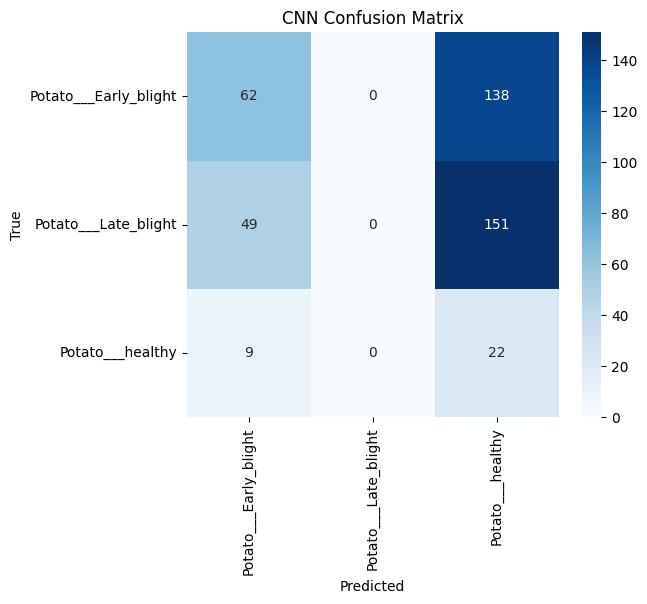

In [39]:
# STEP 14: Confusion Matrix (for CNN)
y_pred_cnn = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_cnn, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

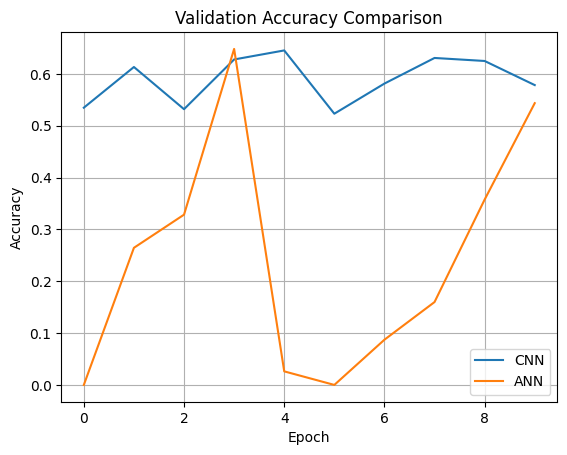

In [40]:
# STEP 15: Accuracy comparison plot
plt.plot(cnn_history.history['val_accuracy'], label='CNN')
plt.plot(ann_history.history['val_accuracy'], label='ANN')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
